Fraud Detection in Credit Card Transactions(Project 10)

In [ ]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, fbeta_score,roc_curve, auc
from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
import streamlit as st
import joblib

1.Kaggle credit card dataset

In [2]:
#Load Dataset
df = pd.read_csv("C:\\Users\\sathw\\Downloads\\creditcard.csv")
print("Shape:", df.shape)
print(df.head())

Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26 

In [3]:
# Check for class imbalance
print("\nClass Distribution:\n", df['Class'].value_counts())


Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


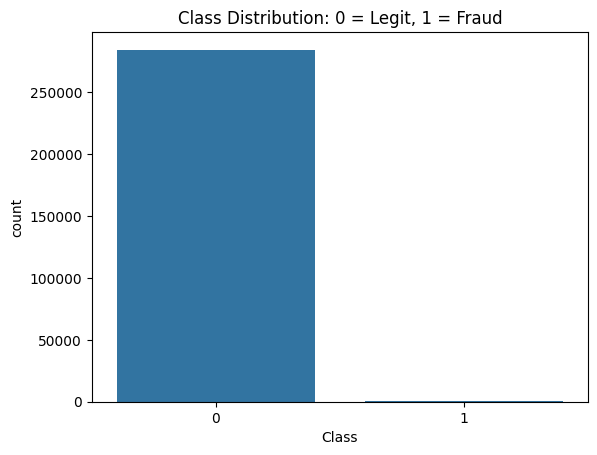

In [4]:
# Visualize class imbalance
sns.countplot(x='Class', data=df)
plt.title("Class Distribution: 0 = Legit, 1 = Fraud")
plt.show()

Exploratory Data Analysis (EDA) and Handle Missing Class Imbalances

2.Preprocess & balance the dataset

In [5]:
# Check for missing values
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [6]:
# Basic stats
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

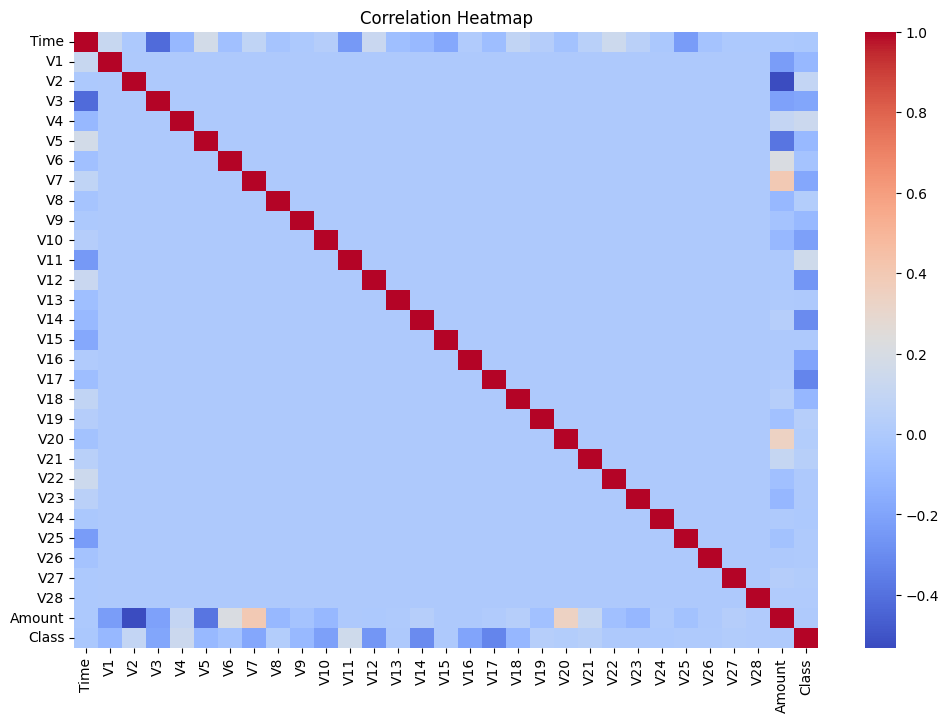

In [7]:
#Correlation HeatMap
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

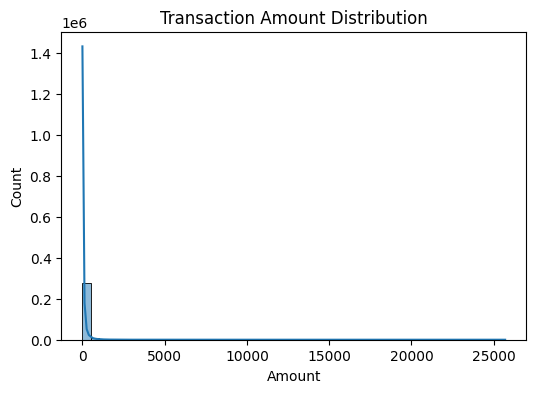

In [8]:
# Distribution of 'Amount'
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

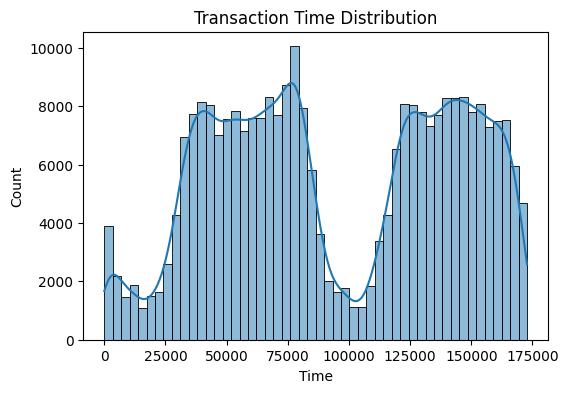

In [9]:
# Distribution of 'Time'
plt.figure(figsize=(6,4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title("Transaction Time Distribution")
plt.show()

3.Apply Isolation Forest & Local Outlier Factor

In [10]:
# Extract features only (no label)
X = df.drop(columns=['Class'])
y = df['Class']

# Fit Isolation Forest
iso = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
y_pred_iso = iso.fit_predict(X)

# Convert output: -1 → fraud (1), 1 → legit (0)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# Evaluation
print("Isolation Forest Results:")
print("\n Confusion Matrix:")
print(confusion_matrix(y, y_pred_iso))
print("\n Classification Report:")
print(classification_report(y, y_pred_iso, digits=4))
print("ROC-AUC:", roc_auc_score(y, y_pred_iso))

Isolation Forest Results:

 Confusion Matrix:
[[283955    360]
 [   367    125]]

 Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9987    0.9987    284315
           1     0.2577    0.2541    0.2559       492

    accuracy                         0.9974    284807
   macro avg     0.6282    0.6264    0.6273    284807
weighted avg     0.9974    0.9974    0.9974    284807

ROC-AUC: 0.6263994197149646


In [11]:
df_sampled = df.sample(n=10000, random_state=42)

X_sampled = df_sampled.drop('Class', axis=1)
y_sampled = df_sampled['Class']

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)   #contamination=0.0017 is based on actual fraud rate in dataset
y_pred_lof = lof.fit_predict(X_sampled)
y_pred_lof = [1 if x == -1 else 0 for x in y_pred_lof]

# Evaluation
print("\n Confusion Matrix:")
print(confusion_matrix(y_sampled, y_pred_lof))
print("\n Classification Report:")
print(classification_report(y_sampled, y_pred_lof, digits=4))
print("ROC-AUC:", roc_auc_score(y_sampled, y_pred_lof))



 Confusion Matrix:
[[9967   17]
 [  16    0]]

 Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9983    0.9983      9984
           1     0.0000    0.0000    0.0000        16

    accuracy                         0.9967     10000
   macro avg     0.4992    0.4991    0.4992     10000
weighted avg     0.9968    0.9967    0.9967     10000

ROC-AUC: 0.49914863782051283


4.Fraud Detection using XGBoost Classifier (with Oversampled Data)

In [12]:
#1.Create Oversampled Dataset
# Separate legit and fraud
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

# Oversample fraud to match legit class size
fraud_oversampled = resample(fraud,replace=True,n_samples=len(legit),random_state=42)
                            
# Combine
df_oversampled = pd.concat([legit, fraud_oversampled])
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced class distribution:\n", df_oversampled['Class'].value_counts())


#2.Train-Test Split
X = df_oversampled.drop('Class', axis=1)
y = df_oversampled['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=42)


#3.Train XGBoost Model
xgb = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

#4.Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\n Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("\n ROC-AUC Score:")
print(roc_auc_score(y_test, y_pred_xgb))

#F2 Score (beta=2 → recall has more weight)
f2 = fbeta_score(y_test, y_pred_xgb, beta=2)
print(f"\n F2-Score: {f2:.4f}")

Balanced class distribution:
 Class
1    284315
0    284315
Name: count, dtype: int64
Confusion Matrix:
[[56853    10]
 [    0 56863]]

 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999     56863
           1     0.9998    1.0000    0.9999     56863

    accuracy                         0.9999    113726
   macro avg     0.9999    0.9999    0.9999    113726
weighted avg     0.9999    0.9999    0.9999    113726


 ROC-AUC Score:
0.999912069359689

 F2-Score: 1.0000


5.Plot ROC Curve for XGBoost

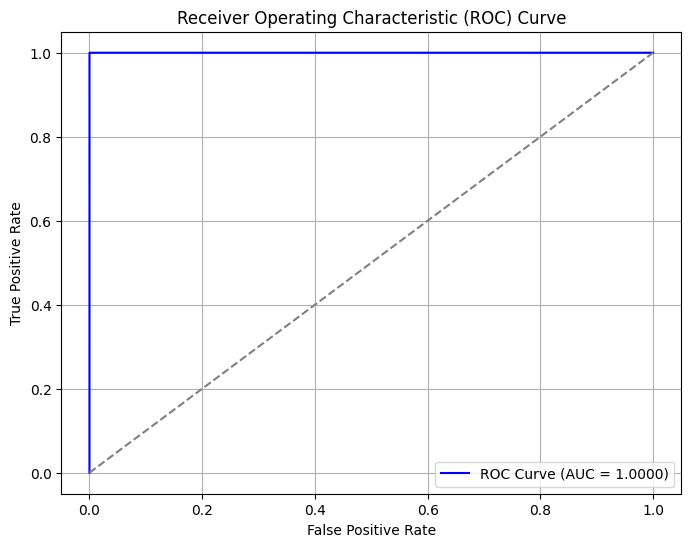

In [13]:
# Predict probabilities
y_prob = xgb.predict_proba(X_test)[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

6.SHAP Explainability 

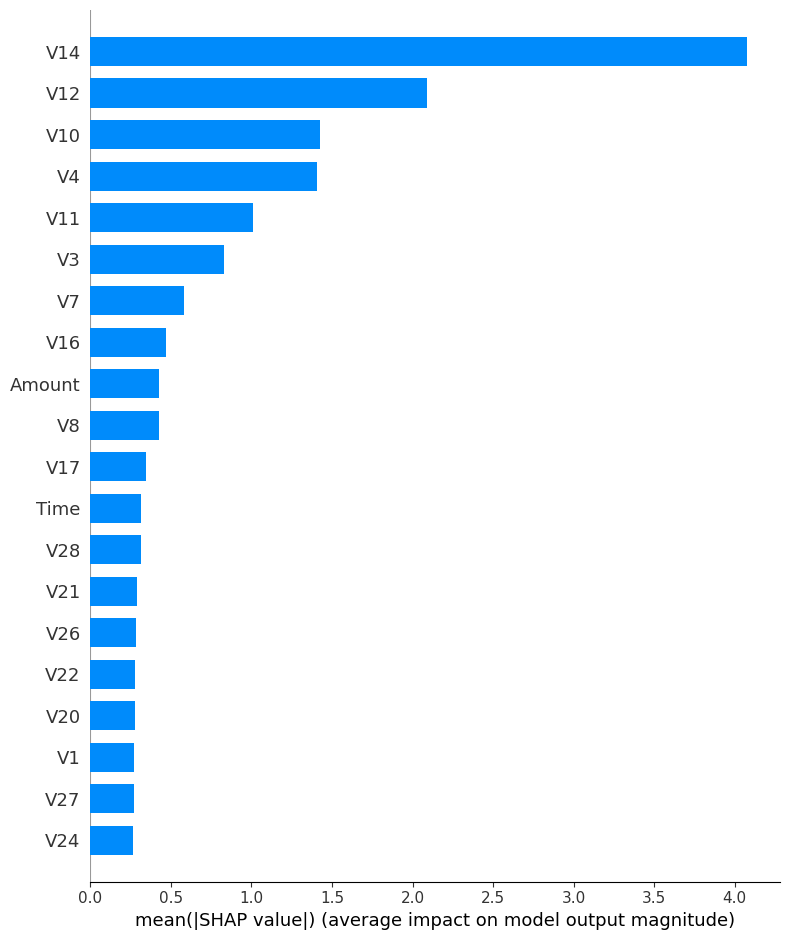

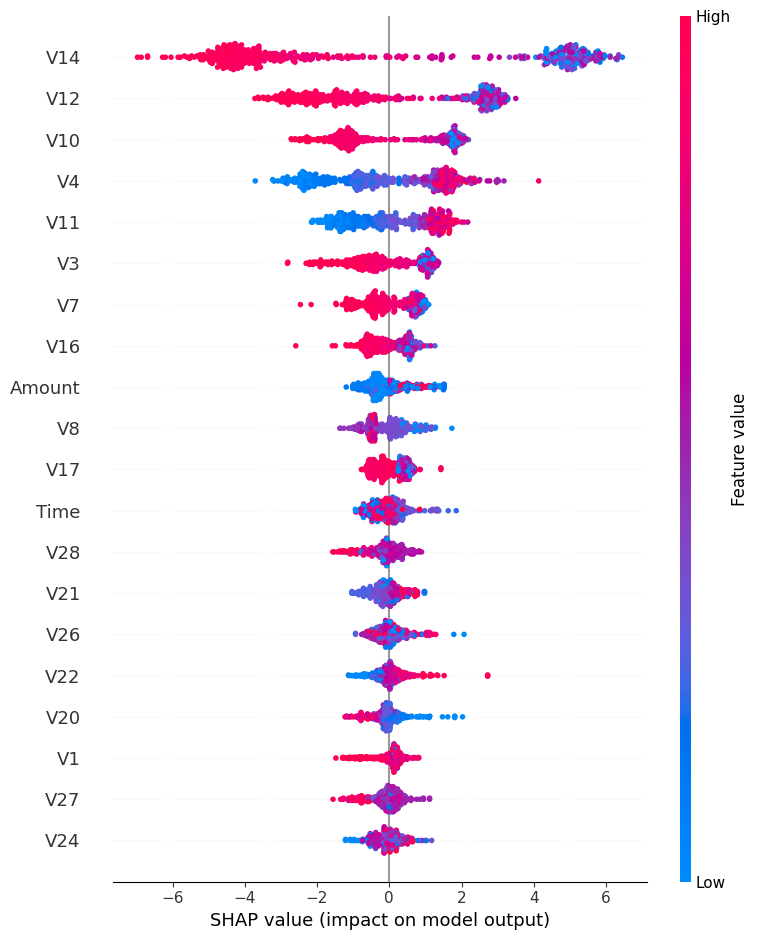

In [16]:
# Use only a subset of test data for performance
X_sample = X_test.iloc[:500]

# Create SHAP TreeExplainer for XGBoost
explainer = shap.Explainer(xgb, X_train)

# Calculate SHAP values for the sample
shap_values = explainer(X_sample)

# Plot bar summary of feature impact
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# (Optional) Detailed beeswarm plot
shap.summary_plot(shap_values, X_sample)


7.Create a Streamlit Dashboard

In [15]:
import joblib

# Save the trained model
joblib.dump(xgb, "xgb_fraud_model.pkl")


['xgb_fraud_model.pkl']